THIS IS A MINI PROJECT DONE BY 



1.   BHANU GUPTA
2.   PRANAV NARAYAN
3.   PURVAV PUNYANI





Step 1: Import all the required models 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt

STEP 2: This code creates a building block for Resnet that will help the network to learn more efficiently. It uses two layers of image filters to process the input image and apply some mathematical operations to it. The output of the second layer is added to the input image, which helps the neural network to better understand the data. 

The basic building block is common in most resnet models 

In [2]:
class block(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(block, self).__init__()
      
        self.conv1 = nn.Conv2d(in_planes
                               , planes, 
                               kernel_size=3, 
                               stride=stride, 
                               padding=1, 
                               bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        
        
        self.conv2 = nn.Conv2d(planes, 
                               planes, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1, 
                               bias=False)
        
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = F.relu(out)
        return out



STEP 3: In this step we modify the ResNet model to keep the number of parameters within 5 million. The modified ResNet architecture has four layers, each made up of a variable number of residual blocks (defined by the num_blocks parameter). Each residual block is made up of two or three convolutional layers, followed by batch normalization and a ReLU activation function. The final layer is a fully connected layer that outputs the predicted class probabilities.



In [3]:

class MOD_ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(MOD_ResNet, self).__init__()


        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        for i in range(num_blocks):
            if i == 0:
                layers.append(block(self.in_planes, planes, stride))
            else:
                layers.append(block(self.in_planes, planes, 1))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
      
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        
        return out

def ResNet_Cifar():
    return MOD_ResNet(block, [3, 4, 6, 2])

STEP 4: WE NOW USE torch.summary to find out the total number of parameters and make sure the total is less than 5 million. In our case the total parameter count is 4,158,090. 

In [4]:
from torchsummary import summary

# Set the device to use for training (CUDA if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet_Cifar().cuda()
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 32, 32, 32]          18,432
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 32, 32, 32]           2,048
       BatchNorm2d-8           [-1, 32, 32, 32]              64
             block-9           [-1, 32, 32, 32]               0
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
           Conv2d-12           [-1, 32, 32, 32]           9,216
      BatchNorm2d-13           [-1, 32, 32, 32]              64
            block-14           [-1, 32,

STEP 5: We define and apply data augmentation and normalization steps to the CIFAR-10 dataset for training and testing. The datasets are loaded using DataLoader with batch size, shuffle, and number of workers specified.

In [5]:
# Define the data augmentation and normalization steps
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, padding=4),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the CIFAR-10 dataset for training
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

# Load the CIFAR-10 dataset for testing
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:05<00:00, 28694904.10it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


STEP 6: We are implementing a deep neural network model for image classification using the ResNet architecture on the CIFAR-10 dataset. We start by setting the device to run on the GPU if available and initializing the model, criterion, optimizer, and scheduler. We define the training and testing functions that iterate over the training and testing data batches and compute the loss, accuracy, and other metrics. We then run a loop for a specified number of epochs, train the model, test it, and save the results in a set of lists. The learning rate scheduler helps adjust the learning rate over time, which can help the model converge to an optimal solution.

In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = ResNet_Cifar().to(device)



criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []


def train(epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Iterate over the training data batches
    for i, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()


    print(f"Epoch: {epoch+1}, Loss: {running_loss/(i+1)}, Train accuracy: {100*correct/total}")
    return running_loss / (i + 1), 100 * correct / total

# Define the testing function for one epoch
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    # Iterate over the test data batches
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    # Print the test accuracy for this epoch
    print(f"        Test accuracy: {100*correct/total}")
    print("-------------------------------------------------------------------------")
    return test_loss / (batch_idx + 1), 100 * correct / total

# Set the number of epochs for training
num_epochs = 100

# Train and test the model for the specified number of epochs
for epoch in range(num_epochs): 
    train_loss, train_acc = train(epoch)  
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    test_loss, test_acc = test(epoch)  
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    scheduler.step()  

Epoch: 1, Loss: 1.4486289472579956, Train accuracy: 46.476
        Test accuracy: 56.81
-------------------------------------------------------------------------
Epoch: 2, Loss: 0.9906906510591507, Train accuracy: 64.876
        Test accuracy: 59.08
-------------------------------------------------------------------------
Epoch: 3, Loss: 0.8152787829637528, Train accuracy: 71.46
        Test accuracy: 71.48
-------------------------------------------------------------------------
Epoch: 4, Loss: 0.7090746042132378, Train accuracy: 75.328
        Test accuracy: 74.42
-------------------------------------------------------------------------
Epoch: 5, Loss: 0.6405783413052559, Train accuracy: 78.032
        Test accuracy: 74.85
-------------------------------------------------------------------------
Epoch: 6, Loss: 0.5942844907641411, Train accuracy: 79.756
        Test accuracy: 77.32
-------------------------------------------------------------------------
Epoch: 7, Loss: 0.55257681280

STEP 7: We use the Matplotlib library to plot the training and test accuracies in a graph with the number of epochs on the x-axis and the accuracy on the y-axis. This plot helps us to visualize how well the model is performing on the training and test sets over time. The plot also includes a legend that labels the two lines representing the training and test accuracies. Finally, the plot is displayed using the plt.show() function.

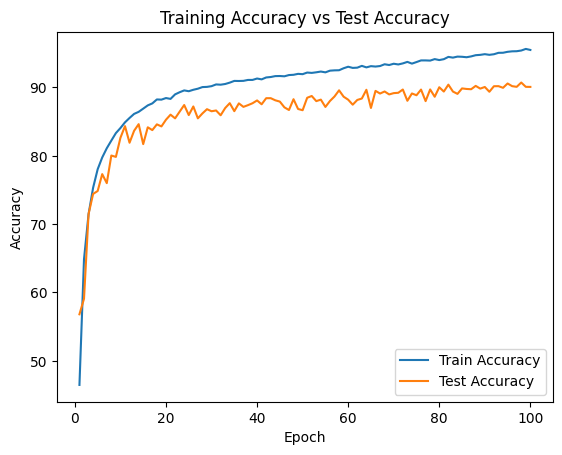

In [7]:
plt.figure()
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Test Accuracy")
plt.legend()
plt.show()